# Predicting a exponentially decacying noisy sine function with overlapping periods

In [1057]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

In [1167]:
# Simulate data
cycle = 100
step = 0.1
noise = 0.1 # standard deviation from 0
decaying_coef = 0.00

end_pt = 2 * np.pi * cycle
t = np.arange(0, end_pt, step)
a = np.sin(t) #* np.sin(0.5 * t) * np.sin(0.2 * t) * np.sin(0.3 * t) * np.sin(2 * t)
a_noisy = a + np.random.normal(0, noise, a.size)
a_decaying = a_noisy * np.exp(-decaying_coef * t)
data = a_decaying

# Note: If noise is not modulated by the exponential function, it will overwhelm the signal near the end of the data sequence
# which is where test data is picked from. We can modulate it in simulated environment but in experiments, we may have to discard
# data near the end of the motion.

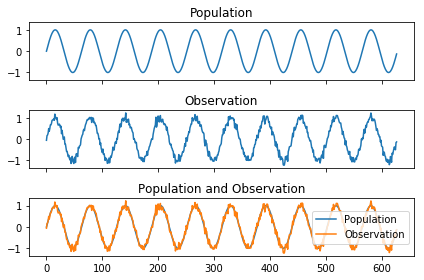

In [1168]:
# visualize data
n_plot = int(a.size/10)

_, axarr = plt.subplots(3, sharex=True, sharey=True)
axarr[0].plot(a[:n_plot])
axarr[0].set_title('Population')
axarr[1].plot(a_decaying[:n_plot])
axarr[1].set_title('Observation')
axarr[2].plot(a[:n_plot], label="Population")
axarr[2].plot(a_decaying[:n_plot], label="Observation")
axarr[2].set_title('Population and Observation')
axarr[2].legend()
plt.tight_layout()
plt.show()

In [1169]:
# hyperparameters
DATA_DIM = 1
N_PREV = 50 # number of previous steps used to predict the next step

In [1170]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)


# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data)

In [1181]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=3, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
# model.add(Dense(units=10, activation="selu"))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [1182]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_split=0.1)

Train on 2217 samples, validate on 247 samples
Epoch 1/20
2217/2217 [==============================] - 9s 4ms/step - loss: 0.2849 - val_loss: 0.1330
Epoch 2/20
2217/2217 [==============================] - 1s 421us/step - loss: 0.0503 - val_loss: 0.0162
Epoch 3/20
2217/2217 [==============================] - 1s 432us/step - loss: 0.0131 - val_loss: 0.0134
Epoch 4/20
2217/2217 [==============================] - 1s 447us/step - loss: 0.0119 - val_loss: 0.0127
Epoch 5/20
2217/2217 [==============================] - 1s 445us/step - loss: 0.0114 - val_loss: 0.0129
Epoch 6/20
2217/2217 [==============================] - 1s 443us/step - loss: 0.0113 - val_loss: 0.0122
Epoch 7/20
2217/2217 [==============================] - 1s 455us/step - loss: 0.0114 - val_loss: 0.0120
Epoch 8/20
2217/2217 [==============================] - 1s 449us/step - loss: 0.0112 - val_loss: 0.0120
Epoch 9/20
2217/2217 [==============================] - 1s 450us/step - loss: 0.0110 - val_loss: 0.0120
Epoch 10/20
2217/22

dict_keys(['val_loss', 'loss'])
20


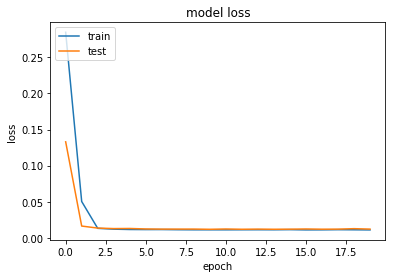

In [1183]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][-30:])
plt.plot(history.history['val_loss'][-30:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1184]:
# evaluate model fit
score = model.evaluate(X_test, y_test)
print('Test score:', score)

3720/3720 [==============================] - 1s 328us/step
Test score: 0.010707997490641892


In [1185]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(list(next_step[0]))
    X_model = np.append(X_model[1:], next_step)

# evaluate
print(np.mean((modelled_data[:len(y_test)]-y_test)**2))

0.35023220107985287


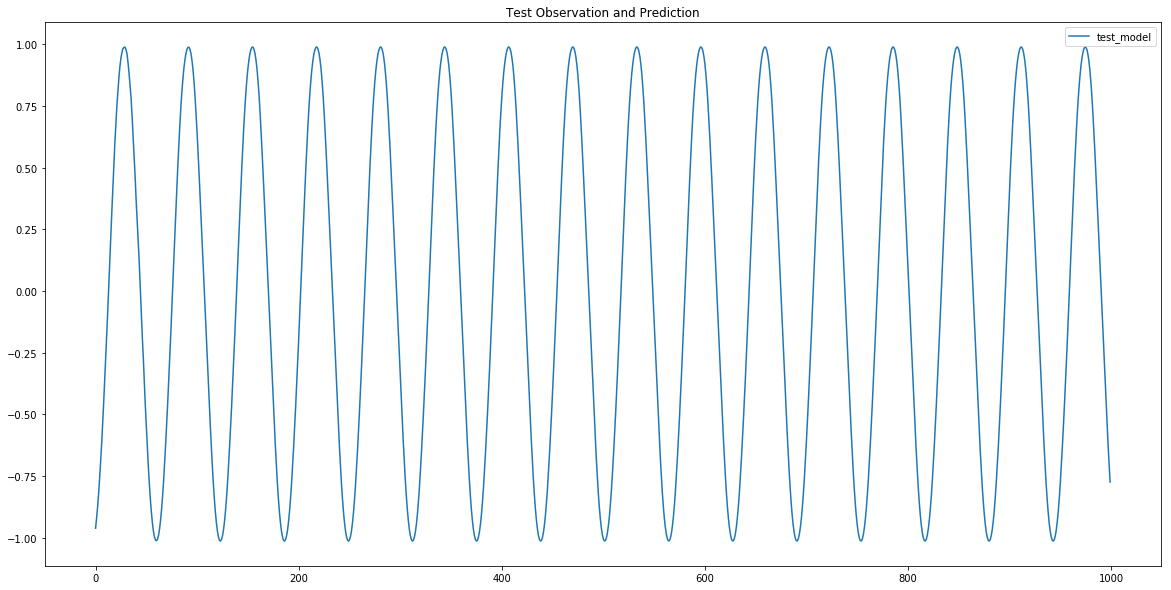

In [1194]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(modelled_data[:1000], label='test_model')
plt.title('Test Observation and Prediction')
plt.legend()

In [1195]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

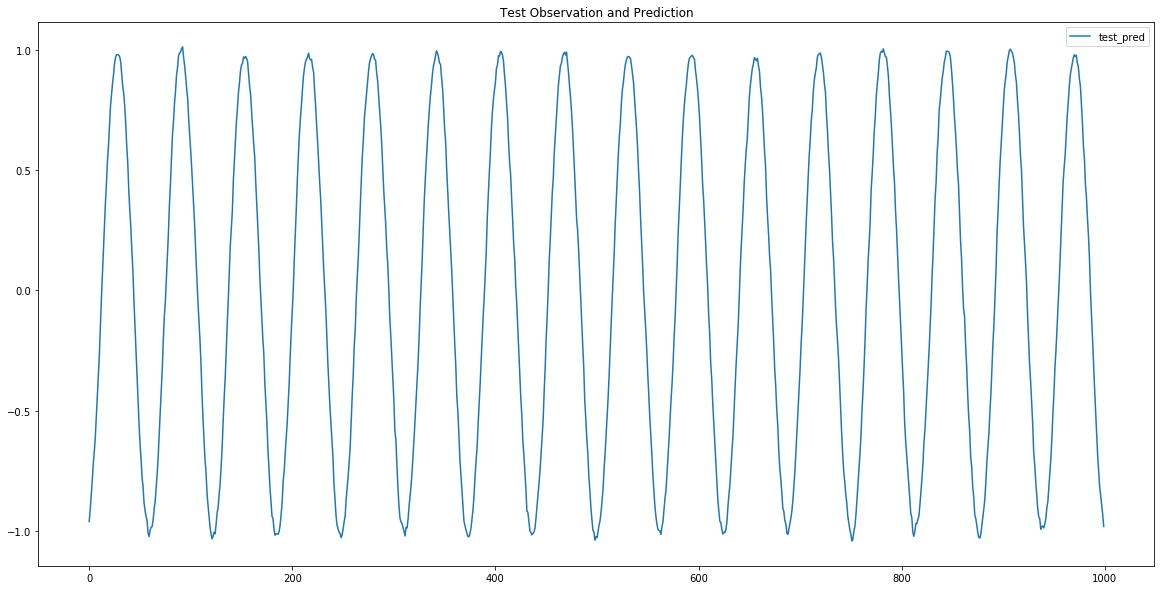

In [1196]:
plt.figure(figsize=(20,10))
# plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:1000], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

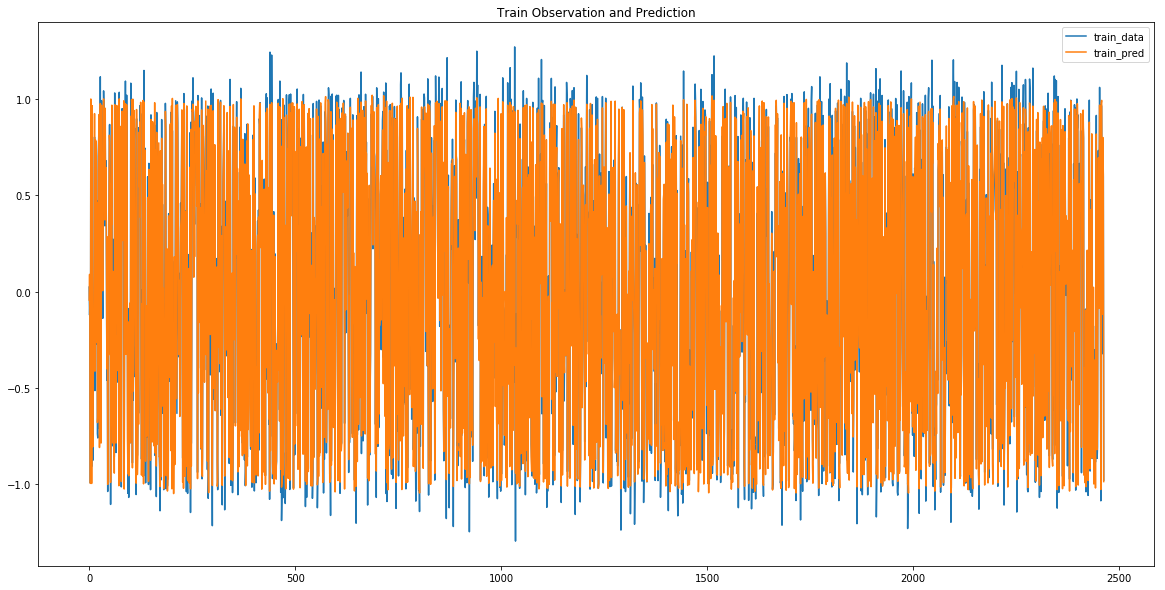

In [1189]:
plt.figure(figsize=(20,10))
plt.plot(y_train[0:], label='train_data')
plt.plot(train_prediction[0:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()